In [1]:
import sys, os, time
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter
from torch.autograd import Variable, grad
from torch.func import vmap
from utils import nvp
from utils import SK
from utils import PT

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scipy.cluster.hierarchy import dendrogram, fcluster, leaves_list, linkage
from scipy.spatial import distance

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

import string
abclist = [ '(' + list(string.ascii_lowercase)[i][0] + ')' for i in range(26)]

In [2]:
dim = 256
n_disorder = 1
T_list = np.asarray(list(np.linspace(0,1,11)[1:]) + list(np.linspace(1,5,11))[1:])
NT = len(T_list)
N = dim
k=0
N_samp = 10000
N_MCMC=10000
N_samples = N_samp
k_disorder = 0

elllist = [0,10,20,30,40,50,60,70,-1]

In [ ]:
## FOR CREATING SAMPLES

def grab(var):
    """Take a tensor off the gpu and convert it to a numpy array on the CPU."""
    return var.detach().cpu().numpy()

def get_samplesSDE(path,N_samp,NT,save_path,dim):
    qlisttest = np.zeros((dim, 9, N_samp, NT))

    for iell in range(9):
        ell = elllist[iell]
        print(f'starting layer: {ell}')
        for i in range(NT):
            iT = T_list[i]
            print(f'begin temp: {iT}')
            T = T_list[iT]

            flow = torch.load(path + f'b{dim}_iT_{iT}_epoch_125_disorder_{0}',map_location=torch.device('cpu'))
            sde  = SDE(flow, interpolant, eps = torch.tensor(2.0), n_step = 80)

            J = SK.generate_J(dim, seed=k)
            beta = 1/T
            Jbar = beta*J
            Jbar_eigs = np.linalg.eig(Jbar)[0]
            bareps = beta*1e-2
            Dbar = (max(0,-min(Jbar_eigs)) + bareps)*np.eye(dim)
            Sigma_inv = Jbar + Dbar
            Sigma_inv_torch = torch.tensor(Sigma_inv, dtype=torch.float32, device=device)

            dim = prior.sample((1, 1)).size()[-1]

            x_init = prior.sample((10000,))
            x_list = sde.solve(x_init)
            x_list_torch = torch.tensor(x_list[ell], dtype=torch.float32, device=device)

            Slist = sample_s_given_x_batch_torch(x_list_torch, Sigma_inv_torch)
            Slist = grab(Slist)

            np.save(f'{save_path}s_list_k_{k}_iT_{iT}_timestep_{ell}.npy', Slist)

            qlisttest[k,iell,:, iT] = np.array([np.sum(Slist[i] * Slist[(i+1) % N_samp]) for i in range(N_samp)]) / dim
            
            print(f'completed temp: {iT}')

    np.save(f'{save_path}qlist.npy', qlisttest)
    print(f'sampling complete, lists saved')

In [4]:
f_ode1024 = 'data/FORWARD_ODE' + str(dim)+'/'
if not os.path.exists(f_ode1024):
    os.makedirs(f_ode1024)

f_sde = 'data/FORWARD_SDE' + str(dim)+'/'
if not os.path.exists(f_sde):
    os.makedirs(f_sde)

r_ode = 'data/REVERSE_ODE' + str(dim)+'/'
if not os.path.exists(r_ode):
    os.makedirs(r_ode)

f_ode256 = 'data/FORWARD_ODE_hidden256' + str(dim)+'/'
if not os.path.exists(f_ode256):
    os.makedirs(f_ode256)

f_ode = 'data/FORWARD_ODE_hidden512' + str(dim)+'/'
if not os.path.exists(f_ode):
    os.makedirs(f_ode)

In [5]:
iT = 2

## PT data
x = np.zeros((1, N_samples))
y = np.zeros((1, N_samples))
for k_disorder in range(1):
    Slist = np.load("data/PT_MCMC256/SlistA_k" + str(k_disorder) + ".npy")[0:N_MCMC]
    print('PT Slist shape: ', Slist.shape)
    for n in range(N_samples):
    
        i1, i2, i3 = np.random.choice(range(N_MCMC), 3, replace=False)

        d12 = (1 - np.dot(Slist[i1, iT], Slist[i2, iT])/N)/2
        d13 = (1 - np.dot(Slist[i1, iT], Slist[i3, iT])/N)/2
        d23 = (1 - np.dot(Slist[i2, iT], Slist[i3, iT])/N)/2

        [dmin, dmid, dmax] = np.sort([d12, d13, d23])
        x[k_disorder, n] = dmid - dmin
        y[k_disorder, n] = dmax - dmid
            
df_PT = pd.DataFrame(data={'x': x.flatten(), 'y': y.flatten()})

## forward data
x = np.zeros((1, N_samples))
y = np.zeros((1, N_samples))
for k_disorder in range(1):
    Slist = np.load(f_ode + 's_list_k_' + str(k_disorder) + '_iT_' + str(iT) + '_timestep_-1.npy')
    print('forward KL Slist shape: ', Slist.shape)
    for n in range(N_samples):
    
        i1, i2, i3 = np.random.choice(range(N_MCMC), 3, replace=False)

        d12 = (1 - np.dot(Slist[i1,:], Slist[i2,:])/N)/2
        d13 = (1 - np.dot(Slist[i1,:], Slist[i3,:])/N)/2
        d23 = (1 - np.dot(Slist[i2,:], Slist[i3,:])/N)/2

        [dmin, dmid, dmax] = np.sort([d12, d13, d23])
        x[k_disorder, n] = dmid - dmin
        y[k_disorder, n] = dmax - dmid
            
df_forward = pd.DataFrame(data={'x': x.flatten(), 'y': y.flatten()})

## reverse data
x = np.zeros((1, N_samples))
y = np.zeros((1, N_samples))
for k_disorder in range(1):
    Slist = np.load(r_ode + 's_list_k_' + str(k_disorder) + '_iT_' + str(iT) + '_timestep_-1.npy')
    print('forward KL Slist shape: ', Slist.shape)
    for n in range(N_samples):
    
        i1, i2, i3 = np.random.choice(range(N_MCMC), 3, replace=False)

        d12 = (1 - np.dot(Slist[i1,:], Slist[i2,:])/N)/2
        d13 = (1 - np.dot(Slist[i1,:], Slist[i3,:])/N)/2
        d23 = (1 - np.dot(Slist[i2,:], Slist[i3,:])/N)/2

        [dmin, dmid, dmax] = np.sort([d12, d13, d23])
        x[k_disorder, n] = dmid - dmin
        y[k_disorder, n] = dmax - dmid
            
df_reverse = pd.DataFrame(data={'x': x.flatten(), 'y': y.flatten()})

PT Slist shape:  (10000, 20, 256)
forward KL Slist shape:  (10000, 256)
forward KL Slist shape:  (10000, 256)


/var/folders/xd/gs9p87p14q190wqtt_1y_m9m0000gn/T/ipykernel_40286/2040110174.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=np.asarray(df_PT.x), y=np.asarray(df_PT.y), cmap=cmap, n_levels=10, shade=True, ax=ax)
/var/folders/xd/gs9p87p14q190wqtt_1y_m9m0000gn/T/ipykernel_40286/2040110174.py:21: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=np.asarray(df_PT.x), y=np.asarray(df_PT.y), cmap=cmap, n_levels=10, shade=True, ax=axb)
/var/folders/xd/gs9p87p14q190wqtt_1y_m9m0000gn/T/ipykernel_40286/2040110174.py:30: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=np.asarray(df_forward.x), y=np.asarray(df_forward.y), cmap=cm

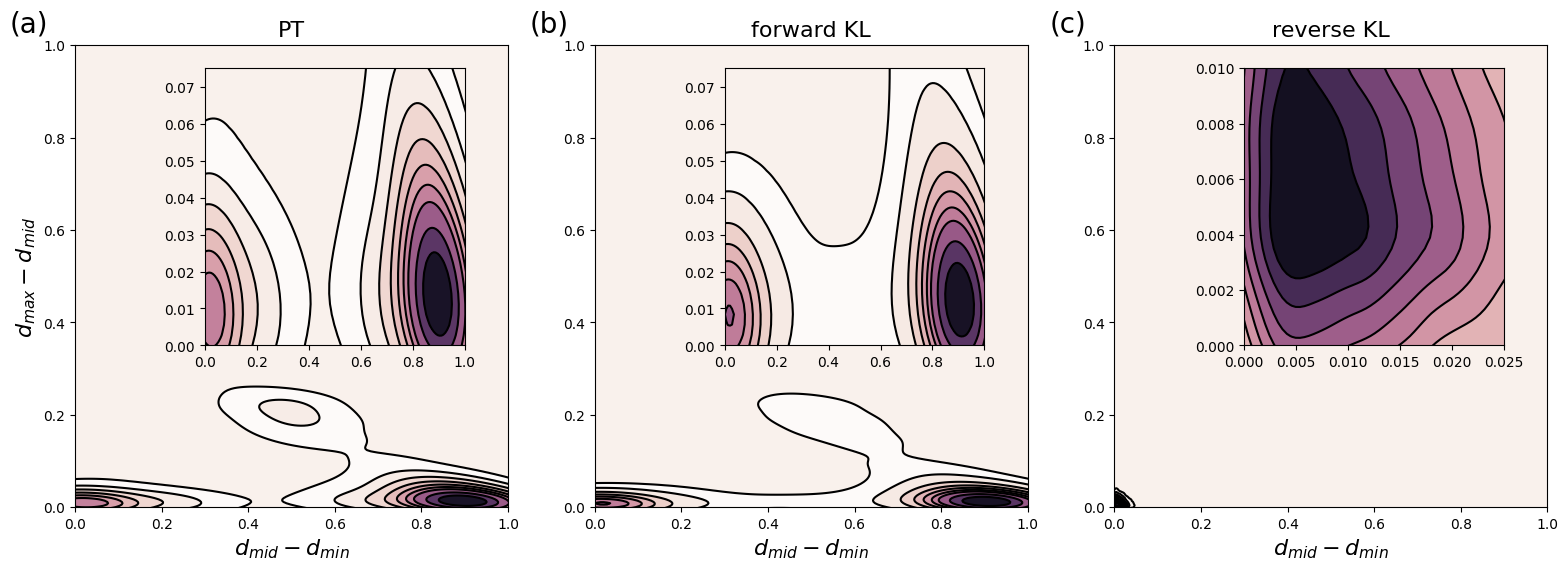

In [7]:
import matplotlib.cm as cm
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(19, 6))
cmap = sns.cubehelix_palette(as_cmap=True, dark=1, light=0, reverse=True)


## PT
ax = ax1
sns.kdeplot(x=np.asarray(df_PT.x), y=np.asarray(df_PT.y), cmap=cmap, n_levels=10, shade=True, ax=ax)
sns.kdeplot(x=np.asarray(df_PT.x), y=np.asarray(df_PT.y), color='k', n_levels=10, ax=ax)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xlabel(r'$d_{mid} - d_{min}$', fontsize=16)
ax.set_ylabel(r'$d_{max} - d_{mid}$', fontsize=16)
ax.text(-0.15, 1.03, '(a)', transform=ax.transAxes, size=20)
ax.text(0.5, 1.02, 'PT', transform=ax.transAxes, horizontalalignment='center', size=16)
ax.set_facecolor(cmap(0.05))

## PT inset
left, bottom, width, height = [0.3, 0.35, 0.6, 0.6]
axb = ax.inset_axes([left, bottom, width, height])
sns.kdeplot(x=np.asarray(df_PT.x), y=np.asarray(df_PT.y), cmap=cmap, n_levels=10, shade=True, ax=axb)
sns.kdeplot(x=np.asarray(df_PT.x), y=np.asarray(df_PT.y), color='k', n_levels=10, ax=axb)
axb.set_xlim(0, 1)
axb.set_ylim(0, 0.075)
axb.set_facecolor(cmap(0.05))


## forward
ax = ax2
sns.kdeplot(x=np.asarray(df_forward.x), y=np.asarray(df_forward.y), cmap=cmap, n_levels=10, shade=True, ax=ax)
sns.kdeplot(x=np.asarray(df_forward.x), y=np.asarray(df_forward.y), color='k', n_levels=10, ax=ax)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xlabel(r'$d_{mid} - d_{min}$', fontsize=16)
#ax.set_ylabel(r'$d_{max} - d_{mid}$')
ax.text(-0.15, 1.03, '(b)', transform=ax.transAxes, size=20)
ax.text(0.5, 1.02, 'forward KL', transform=ax.transAxes, horizontalalignment='center', size=16)
ax.set_facecolor(cmap(0.05))

## forward inset
left, bottom, width, height = [0.3, 0.35, 0.6, 0.6]
axb = ax.inset_axes([left, bottom, width, height])
sns.kdeplot(x=np.asarray(df_forward.x), y=np.asarray(df_forward.y), cmap=cmap, n_levels=10, shade=True, ax=axb)
sns.kdeplot(x=np.asarray(df_forward.x), y=np.asarray(df_forward.y), color='k', n_levels=10, ax=axb)
axb.set_xlim(0, 1)
axb.set_ylim(0, 0.075)
axb.set_facecolor(cmap(0.05))


## reverse
ax = ax3
sns.kdeplot(x=np.asarray(df_reverse.x), y=np.asarray(df_reverse.y), cmap=cmap, n_levels=10, shade=True, ax=ax)
sns.kdeplot(x=np.asarray(df_reverse.x), y=np.asarray(df_reverse.y), color='k', n_levels=10, ax=ax)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xlabel(r'$d_{mid} - d_{min}$', fontsize=16)
#ax.set_ylabel(r'$d_{max} - d_{mid}$')
ax.text(-0.15, 1.03, '(c)', transform=ax.transAxes, size=20)
ax.text(0.5, 1.02, 'reverse KL', transform=ax.transAxes, horizontalalignment='center', size=16)
ax.set_facecolor(cmap(0.05))

## reverse inset
left, bottom, width, height = [0.3, 0.35, 0.6, 0.6]
axb = ax.inset_axes([left, bottom, width, height])
sns.kdeplot(x=np.asarray(df_reverse.x), y=np.asarray(df_reverse.y), cmap=cmap, n_levels=10, shade=True, ax=axb)
sns.kdeplot(x=np.asarray(df_reverse.x), y=np.asarray(df_reverse.y), color='k', n_levels=10, ax=axb)
axb.set_xlim(0, 0.025)
axb.set_ylim(0, 0.01)
axb.set_facecolor(cmap(0.05))


plt.show()

In [8]:
iT = 2

## PT data
x = np.zeros((1, N_samples))
y = np.zeros((1, N_samples))
for k_disorder in range(1):
    Slist = np.load("data/PT_MCMC256/SlistA_k" + str(k_disorder) + ".npy")[0:N_MCMC]
    print('PT Slist shape: ', Slist.shape)
    for n in range(N_samples):
    
        i1, i2, i3 = np.random.choice(range(N_MCMC), 3, replace=False)

        d12 = (1 - np.dot(Slist[i1, iT], Slist[i2, iT])/N)/2
        d13 = (1 - np.dot(Slist[i1, iT], Slist[i3, iT])/N)/2
        d23 = (1 - np.dot(Slist[i2, iT], Slist[i3, iT])/N)/2

        [dmin, dmid, dmax] = np.sort([d12, d13, d23])
        x[k_disorder, n] = dmid - dmin
        y[k_disorder, n] = dmax - dmid
            
df_PT = pd.DataFrame(data={'x': x.flatten(), 'y': y.flatten()})

## forward ode
x = np.zeros((1, N_samples))
y = np.zeros((1, N_samples))
for k_disorder in range(1):
    Slist = np.load(f_ode + 's_list_k_' + str(k_disorder) + '_iT_' + str(iT) + '_timestep_-1.npy')
    print('forward KL Slist shape: ', Slist.shape)
    for n in range(N_samples):
    
        i1, i2, i3 = np.random.choice(range(N_MCMC), 3, replace=False)

        d12 = (1 - np.dot(Slist[i1,:], Slist[i2,:])/N)/2
        d13 = (1 - np.dot(Slist[i1,:], Slist[i3,:])/N)/2
        d23 = (1 - np.dot(Slist[i2,:], Slist[i3,:])/N)/2

        [dmin, dmid, dmax] = np.sort([d12, d13, d23])
        x[k_disorder, n] = dmid - dmin
        y[k_disorder, n] = dmax - dmid
            
df_forwardode = pd.DataFrame(data={'x': x.flatten(), 'y': y.flatten()})

## forward sde
x = np.zeros((1, N_samples))
y = np.zeros((1, N_samples))
for k_disorder in range(1):
    Slist = np.load(f_sde + 's_list_k_' + str(k_disorder) + '_iT_' + str(iT) + '_timestep_-1.npy')
    print('forward KL Slist shape: ', Slist.shape)
    for n in range(N_samples):
    
        i1, i2, i3 = np.random.choice(range(N_MCMC), 3, replace=False)

        d12 = (1 - np.dot(Slist[i1,:], Slist[i2,:])/N)/2
        d13 = (1 - np.dot(Slist[i1,:], Slist[i3,:])/N)/2
        d23 = (1 - np.dot(Slist[i2,:], Slist[i3,:])/N)/2

        [dmin, dmid, dmax] = np.sort([d12, d13, d23])
        x[k_disorder, n] = dmid - dmin
        y[k_disorder, n] = dmax - dmid
            
df_forwardsde = pd.DataFrame(data={'x': x.flatten(), 'y': y.flatten()})

PT Slist shape:  (10000, 20, 256)
forward KL Slist shape:  (10000, 256)
forward KL Slist shape:  (10000, 256)


/var/folders/xd/gs9p87p14q190wqtt_1y_m9m0000gn/T/ipykernel_40286/1425740250.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=np.asarray(df_PT.x), y=np.asarray(df_PT.y), cmap=cmap, n_levels=10, shade=True, ax=ax)
/var/folders/xd/gs9p87p14q190wqtt_1y_m9m0000gn/T/ipykernel_40286/1425740250.py:21: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=np.asarray(df_PT.x), y=np.asarray(df_PT.y), cmap=cmap, n_levels=10, shade=True, ax=axb)
/var/folders/xd/gs9p87p14q190wqtt_1y_m9m0000gn/T/ipykernel_40286/1425740250.py:30: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=np.asarray(df_forwardode.x), y=np.asarray(df_forwardode.y), c

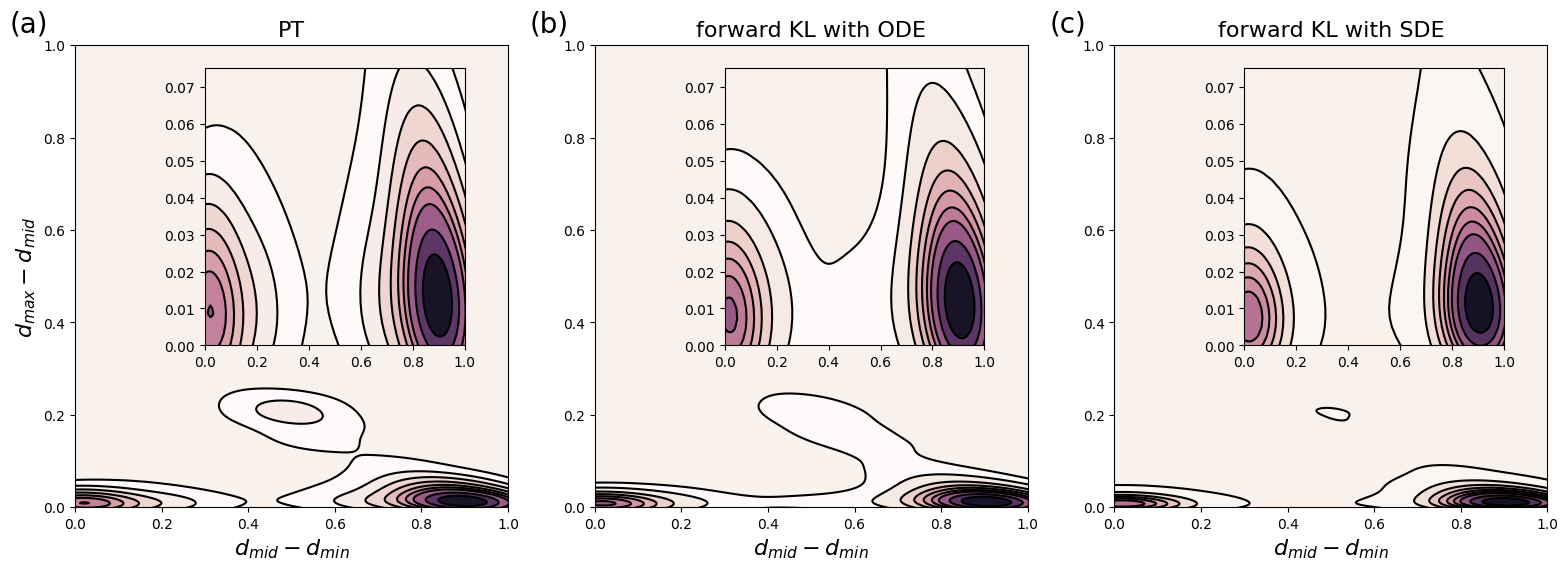

In [10]:
import matplotlib.cm as cm
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(19, 6))
cmap = sns.cubehelix_palette(as_cmap=True, dark=1, light=0, reverse=True)


## PT
ax = ax1
sns.kdeplot(x=np.asarray(df_PT.x), y=np.asarray(df_PT.y), cmap=cmap, n_levels=10, shade=True, ax=ax)
sns.kdeplot(x=np.asarray(df_PT.x), y=np.asarray(df_PT.y), color='k', n_levels=10, ax=ax)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xlabel(r'$d_{mid} - d_{min}$', fontsize=16)
ax.set_ylabel(r'$d_{max} - d_{mid}$', fontsize=16)
ax.text(-0.15, 1.03, '(a)', transform=ax.transAxes, size=20)
ax.text(0.5, 1.02, 'PT', transform=ax.transAxes, horizontalalignment='center', size=16)
ax.set_facecolor(cmap(0.05))

## PT inset
left, bottom, width, height = [0.3, 0.35, 0.6, 0.6]
axb = ax.inset_axes([left, bottom, width, height])
sns.kdeplot(x=np.asarray(df_PT.x), y=np.asarray(df_PT.y), cmap=cmap, n_levels=10, shade=True, ax=axb)
sns.kdeplot(x=np.asarray(df_PT.x), y=np.asarray(df_PT.y), color='k', n_levels=10, ax=axb)
axb.set_xlim(0, 1)
axb.set_ylim(0, 0.075)
axb.set_facecolor(cmap(0.05))


## forward
ax = ax2
sns.kdeplot(x=np.asarray(df_forwardode.x), y=np.asarray(df_forwardode.y), cmap=cmap, n_levels=10, shade=True, ax=ax)
sns.kdeplot(x=np.asarray(df_forwardode.x), y=np.asarray(df_forwardode.y), color='k', n_levels=10, ax=ax)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xlabel(r'$d_{mid} - d_{min}$', fontsize=16)
#ax.set_ylabel(r'$d_{max} - d_{mid}$')
ax.text(-0.15, 1.03, '(b)', transform=ax.transAxes, size=20)
ax.text(0.5, 1.02, 'forward KL with ODE', transform=ax.transAxes, horizontalalignment='center', size=16)
ax.set_facecolor(cmap(0.05))

## forward inset
left, bottom, width, height = [0.3, 0.35, 0.6, 0.6]
axb = ax.inset_axes([left, bottom, width, height])
sns.kdeplot(x=np.asarray(df_forwardode.x), y=np.asarray(df_forwardode.y), cmap=cmap, n_levels=10, shade=True, ax=axb)
sns.kdeplot(x=np.asarray(df_forwardode.x), y=np.asarray(df_forwardode.y), color='k', n_levels=10, ax=axb)
axb.set_xlim(0, 1)
axb.set_ylim(0, 0.075)
axb.set_facecolor(cmap(0.05))


## reverse
ax = ax3
sns.kdeplot(x=np.asarray(df_forwardsde.x), y=np.asarray(df_forwardsde.y), cmap=cmap, n_levels=10, shade=True, ax=ax)
sns.kdeplot(x=np.asarray(df_forwardsde.x), y=np.asarray(df_forwardsde.y), color='k', n_levels=10, ax=ax)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xlabel(r'$d_{mid} - d_{min}$', fontsize=16)
#ax.set_ylabel(r'$d_{max} - d_{mid}$')
ax.text(-0.15, 1.03, '(c)', transform=ax.transAxes, size=20)
ax.text(0.5, 1.02, 'forward KL with SDE', transform=ax.transAxes, horizontalalignment='center', size=16)
ax.set_facecolor(cmap(0.05))

## reverse inset
left, bottom, width, height = [0.3, 0.35, 0.6, 0.6]
axb = ax.inset_axes([left, bottom, width, height])
sns.kdeplot(x=np.asarray(df_forwardsde.x), y=np.asarray(df_forwardsde.y), cmap=cmap, n_levels=10, shade=True, ax=axb)
sns.kdeplot(x=np.asarray(df_forwardsde.x), y=np.asarray(df_forwardsde.y), color='k', n_levels=10, ax=axb)
axb.set_xlim(0, 1)
axb.set_ylim(0, 0.075)
axb.set_facecolor(cmap(0.05))


plt.show()

In [12]:
qlist_PT = np.asarray([np.load('data/PT_MCMC256/'+'qlist_k' + str(k) + '.npy') for k in range(n_disorder)])
FULLqlist_forward = np.load(f_ode+'qlist.npy')
FULLqlist_reverse = np.load(r_ode+'qlist.npy')
FULLqlist_forward_sde = np.load(f_sde+'qlist.npy')
FULLqlist_forward256 = np.load(f_ode256+'qlist.npy')
FULLqlist_forward1024 = np.load(f_ode1024+'qlist.npy')

qlist_forward = FULLqlist_forward[:,-1,:,:]
qlist_forward256 = FULLqlist_forward256[:,-1,:,:]
qlist_forward1024 = FULLqlist_forward1024[:,-1,:,:]
qlist_forward_sde = FULLqlist_forward_sde[:,-1,:,:]
qlist_reverse = FULLqlist_reverse[:,-1,:,:]


/var/folders/xd/gs9p87p14q190wqtt_1y_m9m0000gn/T/ipykernel_40286/1790265291.py:18: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(qlist_PT_big, shade=True, label = 'PT', ax=ax, clip = (-1, 1))
/var/folders/xd/gs9p87p14q190wqtt_1y_m9m0000gn/T/ipykernel_40286/1790265291.py:19: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(qlist_NVP_reverse_big, shade=True, label = 'flow (reverse)', ax=ax, clip = (-1, 1))
/var/folders/xd/gs9p87p14q190wqtt_1y_m9m0000gn/T/ipykernel_40286/1790265291.py:20: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(qlist_NVP_forward_big, shade=True, label = 'flow (forward)', ax=ax, clip = (-1, 1))
/var/folde

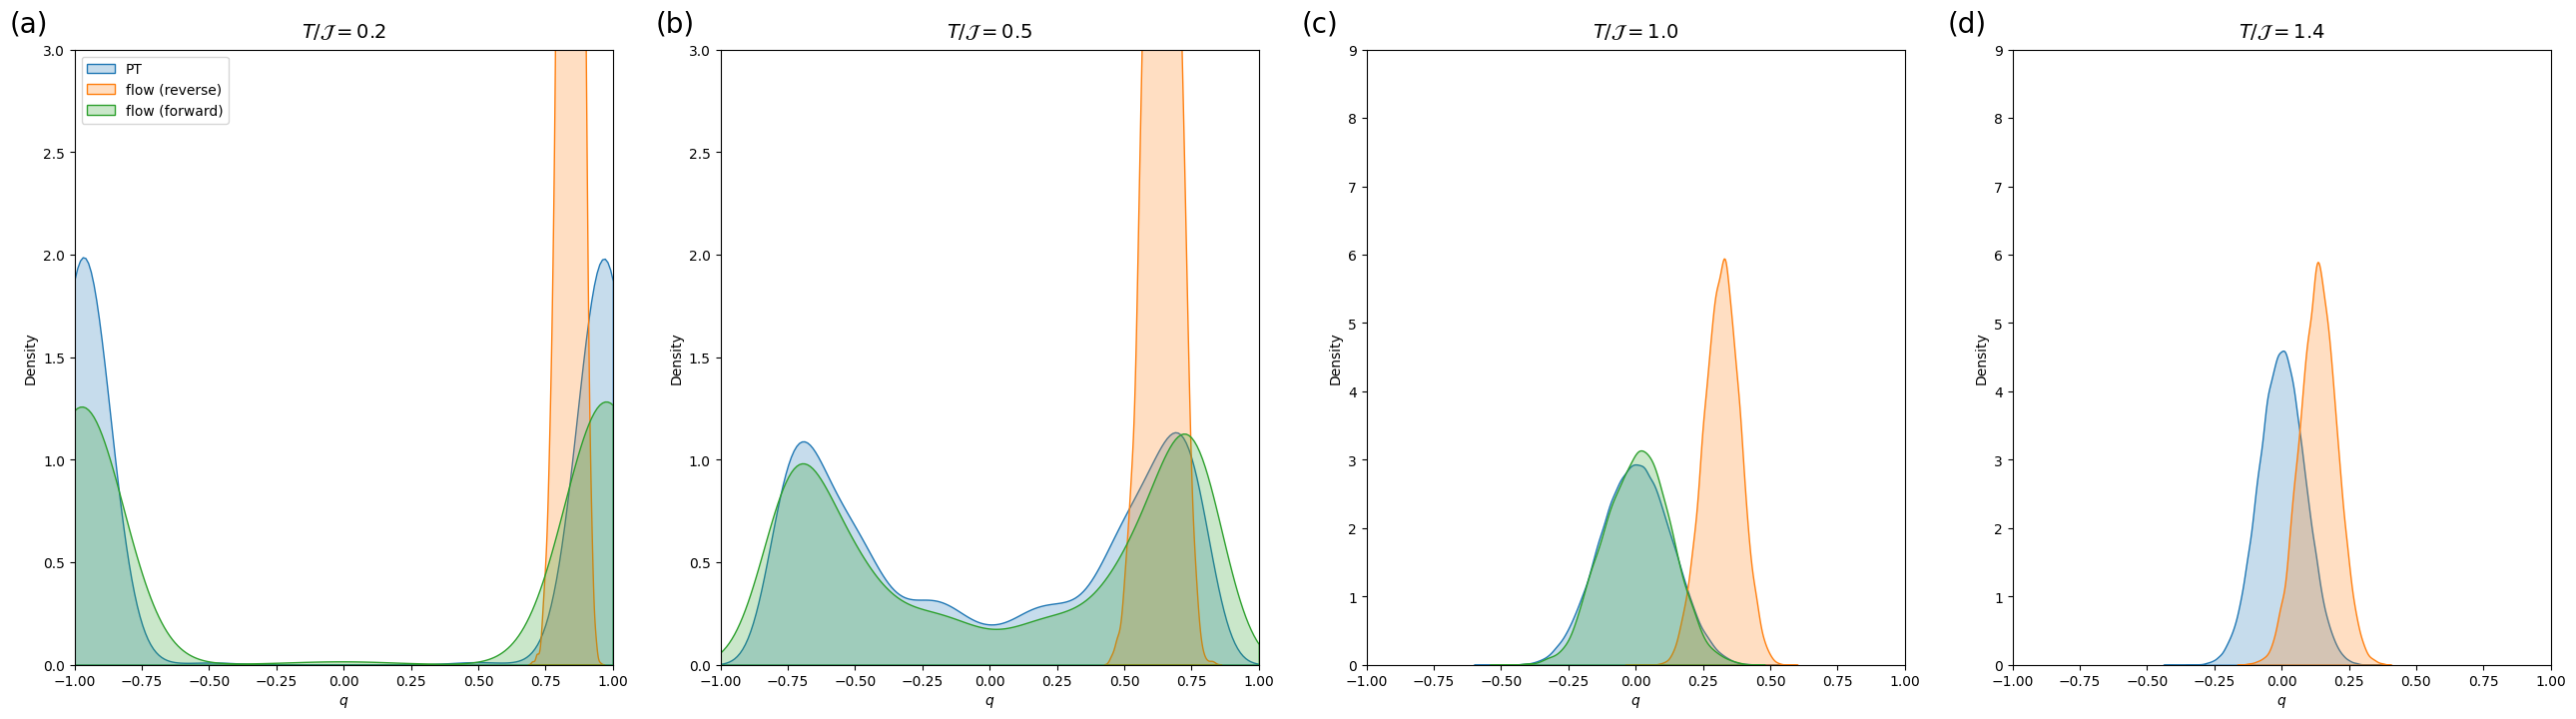

In [16]:
fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(1, 4, figsize=(32, 8))
iTlist = [1, 4, 9, 10]
xlim_list = []

## overlaps
axlist = [ax1, ax2, ax3, ax4]
ylim_list = [2, 2, 6, 6]

for i in range(4):
    iT = iTlist[i]
    ax = axlist[i]
 
    qlist_PT_big = qlist_PT[k_disorder,:,iT].flatten()
    qlist_NVP_forward_big = qlist_forward[k_disorder,:,iT].flatten()
    qlist_NVP_reverse_big = qlist_reverse[k_disorder,:,iT].flatten()

    if i == 0:
        sns.kdeplot(qlist_PT_big, shade=True, label = 'PT', ax=ax, clip = (-1, 1))
        sns.kdeplot(qlist_NVP_reverse_big, shade=True, label = 'flow (reverse)', ax=ax, clip = (-1, 1))
        sns.kdeplot(qlist_NVP_forward_big, shade=True, label = 'flow (forward)', ax=ax, clip = (-1, 1))        
    else:
        sns.kdeplot(qlist_PT_big, shade=True, ax=ax, clip = (-1, 1))
        sns.kdeplot(qlist_NVP_reverse_big, shade=True, ax=ax, clip = (-1, 1))
        sns.kdeplot(qlist_NVP_forward_big, shade=True, ax=ax, clip = (-1, 1))
    
    ax.set_xlabel(r'$q$')
    ax.set_xlim(-1, 1)
    ax.set_ylim(0, 1.5*ylim_list[i])
    if i == 0:
        ax.legend(loc='upper left')
    ax.text(-0.12, 1.03, abclist[i], transform=ax.transAxes, size=20)
    ax.text(0.5, 1.02, (r'$T/\mathcal{J} = $%.1f' % T_list[iT]), transform=ax.transAxes, \
            horizontalalignment='center', size=14)
    
plt.show()

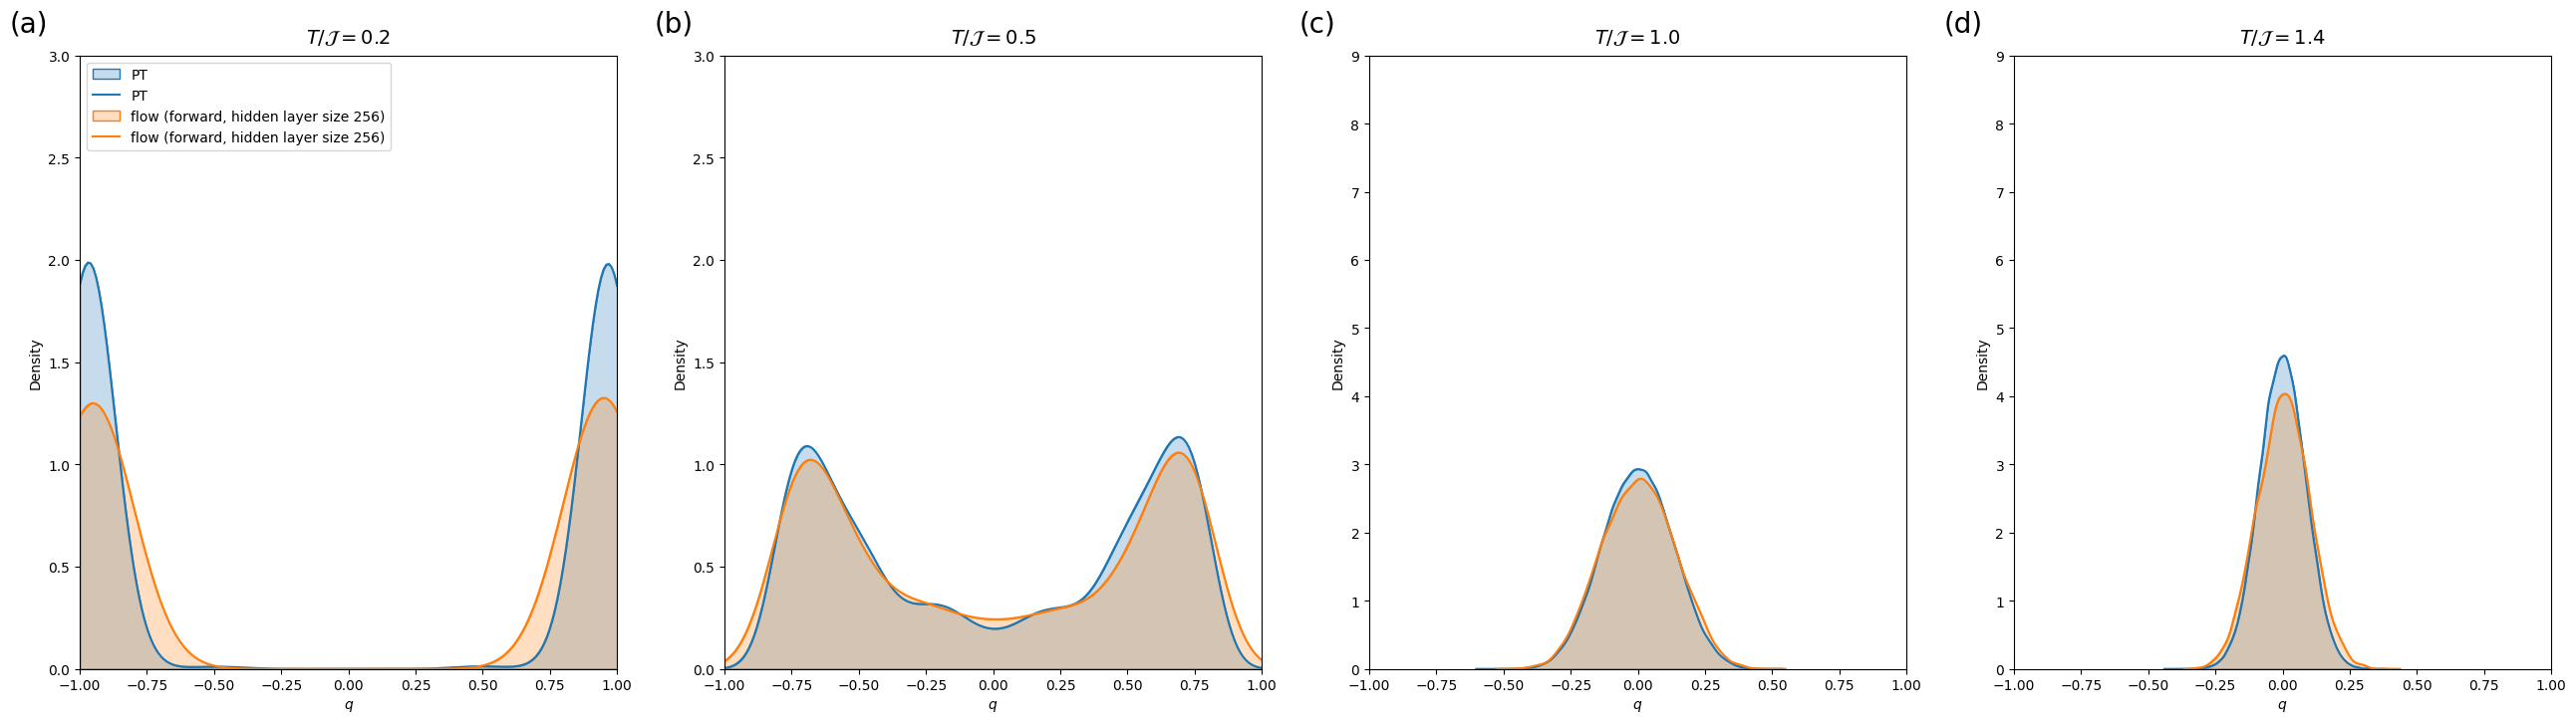

In [17]:
fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(1, 4, figsize=(32, 8))
iTlist = [1, 4, 9, 10]
xlim_list = []

## overlaps
axlist = [ax1, ax2, ax3, ax4]
ylim_list = [2, 2, 6, 6]

for i in range(4):
    iT = iTlist[i]
    ax = axlist[i]
 
    qlist_PT_big = qlist_PT[k_disorder,:,iT].flatten()
    qlist_forward_big = qlist_forward256[k_disorder,:,iT].flatten()

    if i == 0:
        sns.kdeplot(qlist_PT_big, fill=True, label = 'PT', ax=ax, clip = (-1, 1))
        sns.kdeplot(qlist_PT_big, fill=False, label = 'PT', ax=ax, clip = (-1, 1))

        sns.kdeplot(qlist_forward_big, fill=True, label = 'flow (forward, hidden layer size 256)', ax=ax, clip = (-1, 1))        
        sns.kdeplot(qlist_forward_big, fill=False, label = 'flow (forward, hidden layer size 256)', ax=ax, clip = (-1, 1))        
    
    else:
        sns.kdeplot(qlist_PT_big, fill=True, ax=ax, clip = (-1, 1))
        sns.kdeplot(qlist_PT_big, fill=False, ax=ax, clip = (-1, 1))

        sns.kdeplot(qlist_forward_big, fill=True, ax=ax, clip = (-1, 1))
        sns.kdeplot(qlist_forward_big, fill=False, ax=ax, clip = (-1, 1))

    ax.set_xlabel(r'$q$')
    ax.set_xlim(-1, 1)
    ax.set_ylim(0, 1.5*ylim_list[i])
    if i == 0:
        ax.legend(loc='upper left')
    ax.text(-0.13, 1.04, abclist[i], transform=ax.transAxes, size=20)
    ax.text(0.5, 1.02, (r'$T/\mathcal{J} = $%.1f' % T_list[iT]), transform=ax.transAxes, \
            horizontalalignment='center', size=14)
    ax.set_xticks([-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1.0])

plt.show()

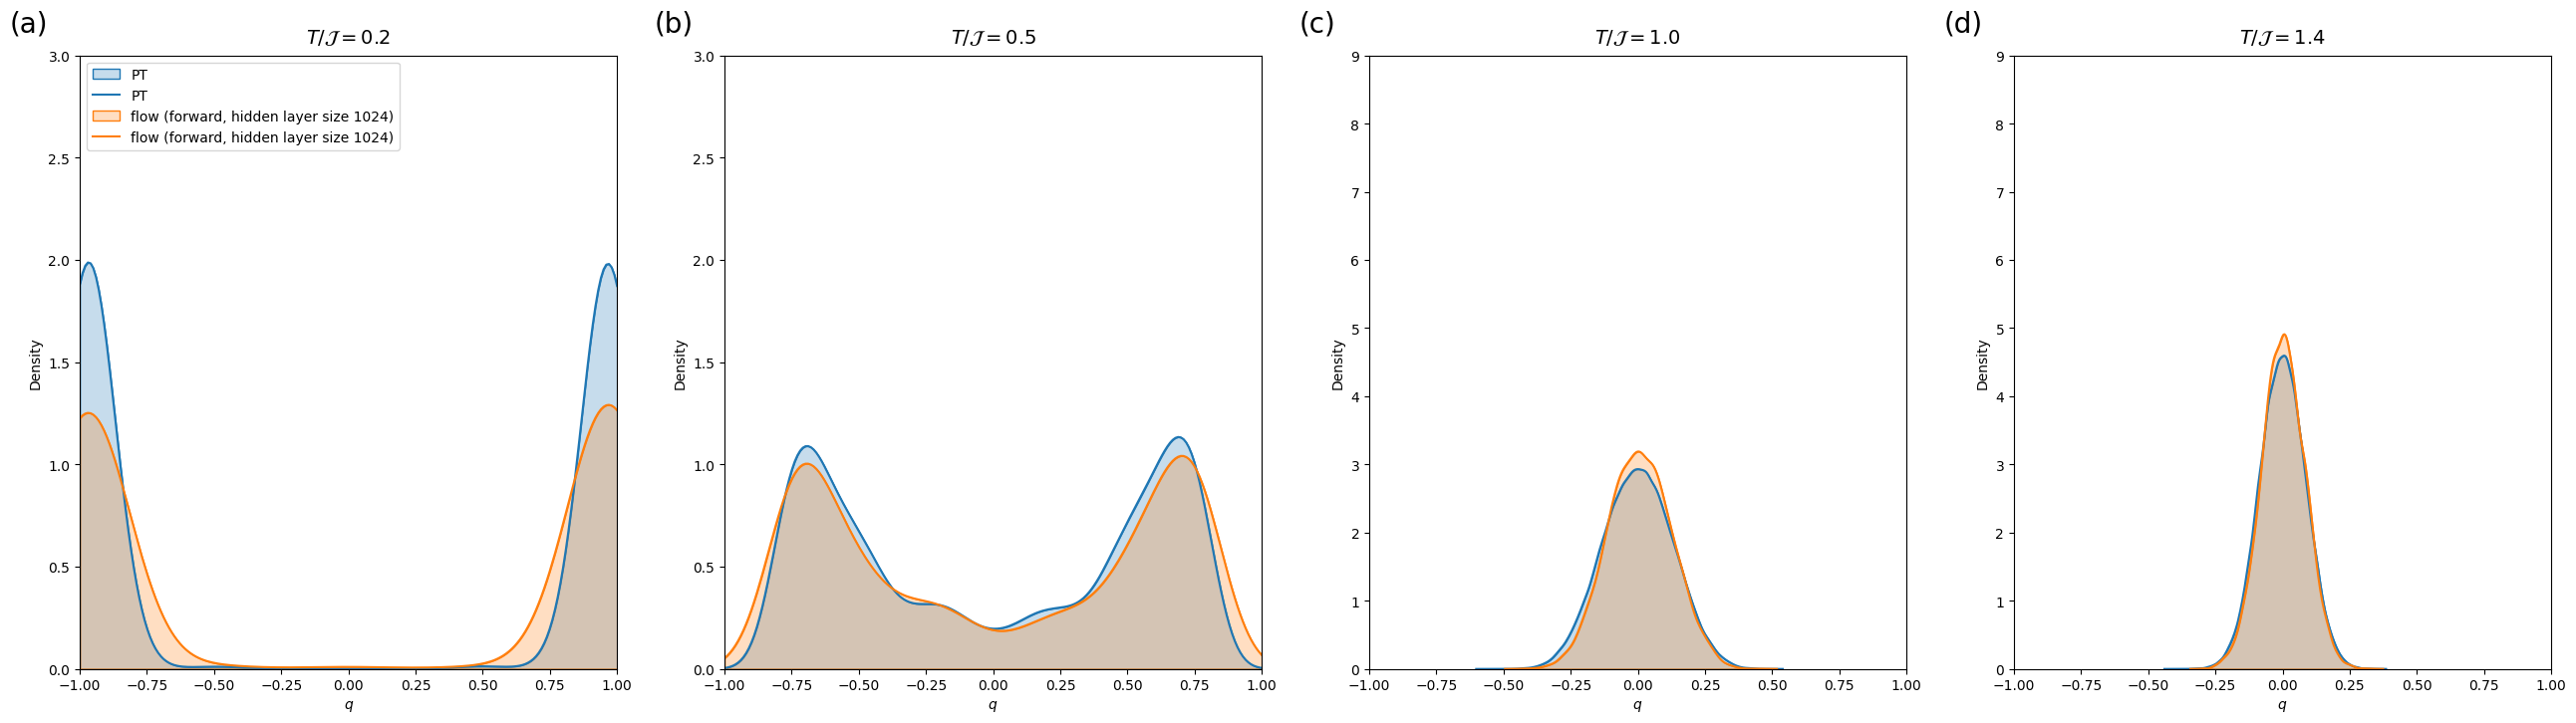

In [18]:
fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(1, 4, figsize=(32, 8))
iTlist = [1, 4, 9, 10]
xlim_list = []

## overlaps
axlist = [ax1, ax2, ax3, ax4]
ylim_list = [2, 2, 6, 6]

for i in range(4):
    iT = iTlist[i]
    ax = axlist[i]
 
    qlist_PT_big = qlist_PT[k_disorder,:,iT].flatten()
    qlist_forward_big = qlist_forward1024[k_disorder,:,iT].flatten()

    if i == 0:
        sns.kdeplot(qlist_PT_big, fill=True, label = 'PT', ax=ax, clip = (-1, 1))
        sns.kdeplot(qlist_PT_big, fill=False, label = 'PT', ax=ax, clip = (-1, 1))

        sns.kdeplot(qlist_forward_big, fill=True, label = 'flow (forward, hidden layer size 1024)', ax=ax, clip = (-1, 1))        
        sns.kdeplot(qlist_forward_big, fill=False, label = 'flow (forward, hidden layer size 1024)', ax=ax, clip = (-1, 1))        
    
    else:
        sns.kdeplot(qlist_PT_big, fill=True, ax=ax, clip = (-1, 1))
        sns.kdeplot(qlist_PT_big, fill=False, ax=ax, clip = (-1, 1))

        sns.kdeplot(qlist_forward_big, fill=True, ax=ax, clip = (-1, 1))
        sns.kdeplot(qlist_forward_big, fill=False, ax=ax, clip = (-1, 1))

    ax.set_xlabel(r'$q$')
    ax.set_xlim(-1, 1)
    ax.set_ylim(0, 1.5*ylim_list[i])
    if i == 0:
        ax.legend(loc='upper left')
    ax.text(-0.13, 1.04, abclist[i], transform=ax.transAxes, size=20)
    ax.text(0.5, 1.02, (r'$T/\mathcal{J} = $%.1f' % T_list[iT]), transform=ax.transAxes, \
            horizontalalignment='center', size=14)
    ax.set_xticks([-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1.0])

plt.show()

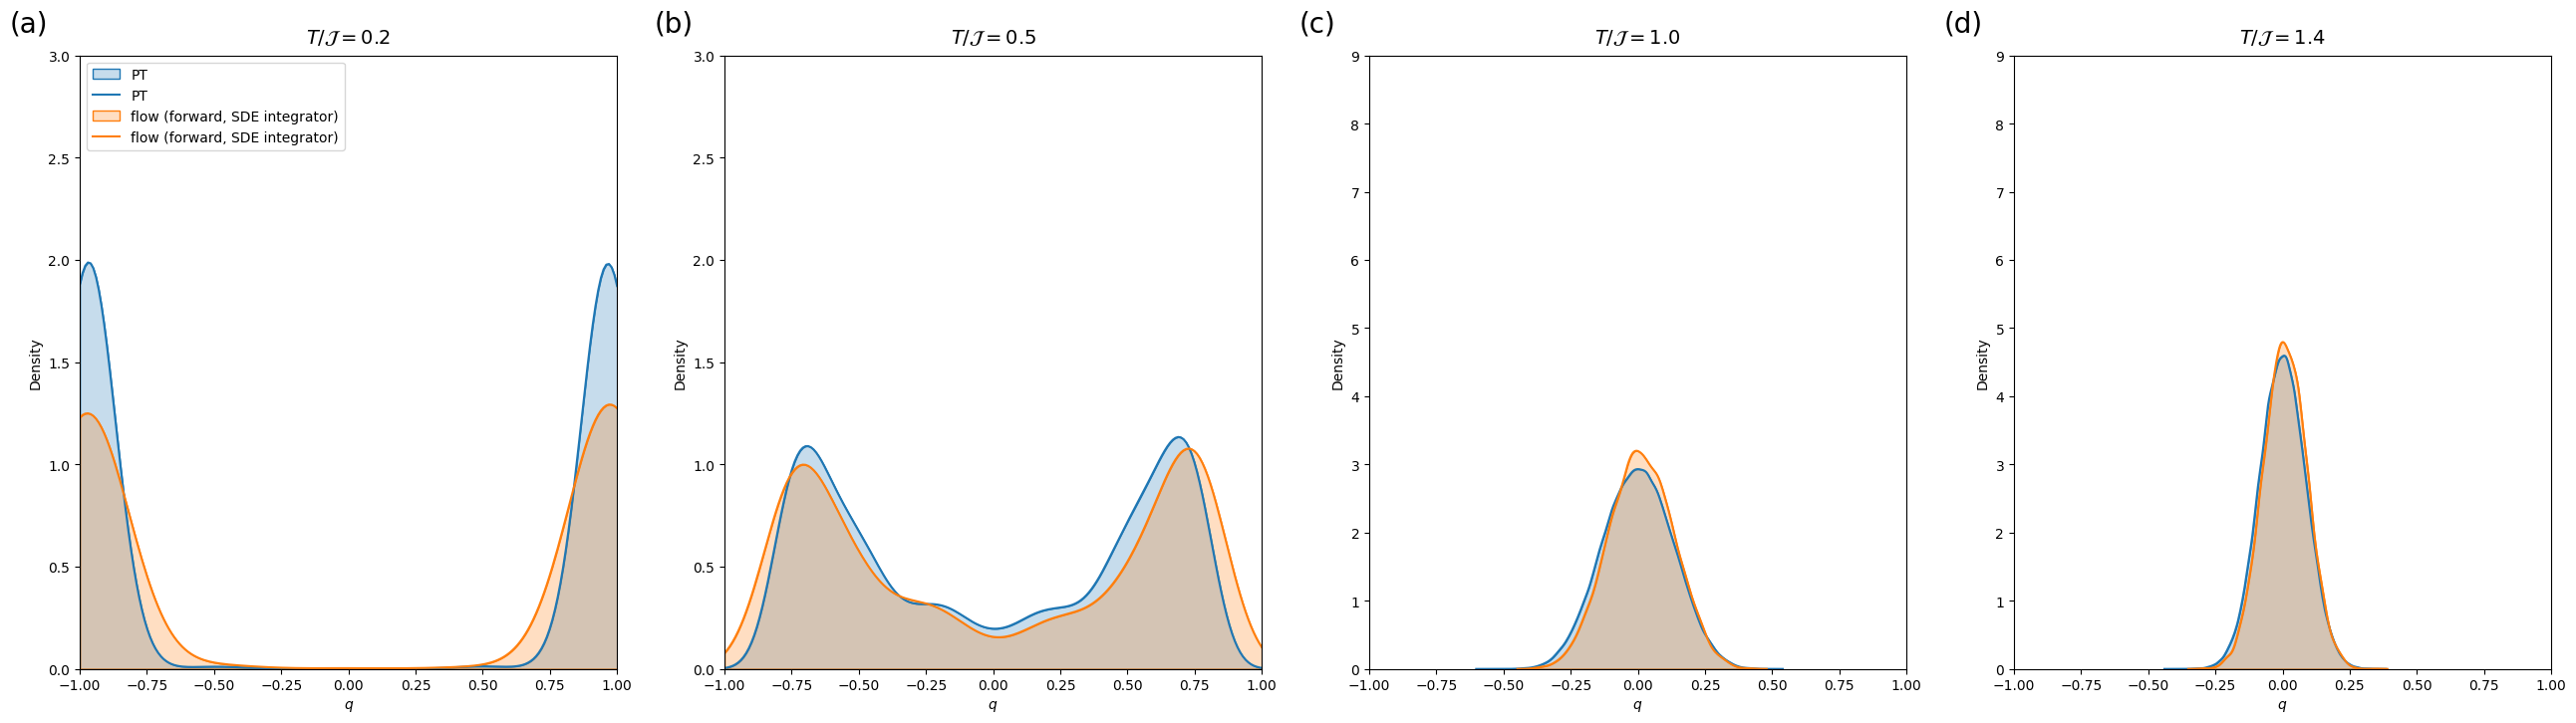

In [25]:
fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(1, 4, figsize=(32, 8))
iTlist = [1, 4, 9, 10]
xlim_list = []

## overlaps
axlist = [ax1, ax2, ax3, ax4]
ylim_list = [2, 2, 6, 6]

for i in range(4):
    iT = iTlist[i]
    ax = axlist[i]
 
    qlist_PT_big = qlist_PT[k_disorder,:,iT].flatten()
    qlist_forward_big = qlist_forward_sde[k_disorder,:,iT].flatten()

    if i == 0:
        sns.kdeplot(qlist_PT_big, fill=True, label = 'PT', ax=ax, clip = (-1, 1))
        sns.kdeplot(qlist_PT_big, fill=False, label = 'PT', ax=ax, clip = (-1, 1))

        sns.kdeplot(qlist_forward_big, fill=True, label = 'flow (forward, SDE integrator)', ax=ax, clip = (-1, 1))        
        sns.kdeplot(qlist_forward_big, fill=False, label = 'flow (forward, SDE integrator)', ax=ax, clip = (-1, 1))        
    
    else:
        sns.kdeplot(qlist_PT_big, fill=True, ax=ax, clip = (-1, 1))
        sns.kdeplot(qlist_PT_big, fill=False, ax=ax, clip = (-1, 1))

        sns.kdeplot(qlist_forward_big, fill=True, ax=ax, clip = (-1, 1))
        sns.kdeplot(qlist_forward_big, fill=False, ax=ax, clip = (-1, 1))

    ax.set_xlabel(r'$q$')
    ax.set_xlim(-1, 1)
    ax.set_ylim(0, 1.5*ylim_list[i])
    if i == 0:
        ax.legend(loc='upper left')
    ax.text(-0.13, 1.04, abclist[i], transform=ax.transAxes, size=20)
    ax.text(0.5, 1.02, (r'$T/\mathcal{J} = $%.1f' % T_list[iT]), transform=ax.transAxes, \
            horizontalalignment='center', size=14)
    ax.set_xticks([-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1.0])

plt.show()

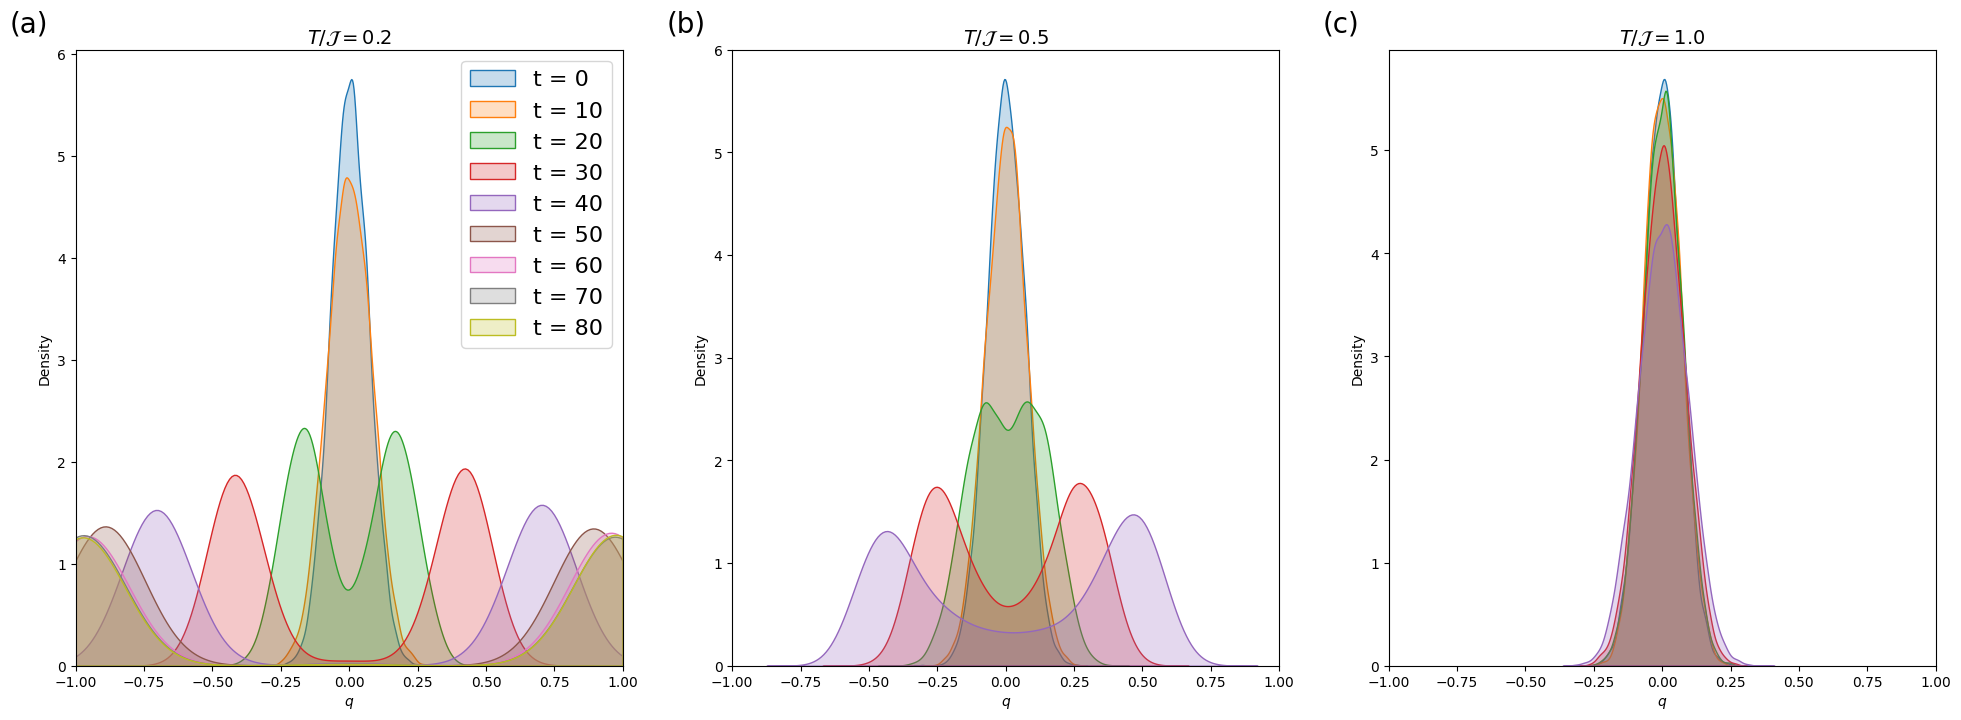

In [21]:
fig, axarr = plt.subplots(1, 3, figsize = (24,8))
timesteps = [0, 10, 20, 30, 40, 50, 60, 70, 80]
for ia in range(len(axarr)):
    iT = [1, 4, 9][ia]

    if ia == 0:
        for ell in range(9):
            sns.kdeplot(FULLqlist_forward[k_disorder, ell,:,iT].flatten(), fill=True, \
                        label=f't = {timesteps[ell]}', ax=axarr[ia], clip = (-1, 1))
        axarr[ia].legend(fontsize=16)
    
    else:
        for ell in range(5):
            sns.kdeplot(FULLqlist_forward[k_disorder, ell,:,iT].flatten(), fill=True, ax=axarr[ia], clip = (-1, 1))    
    axarr[ia].set_xlim(-1,1)
    axarr[ia].set_xlabel(r'$q$')
    axarr[ia].text(-0.12, 1.03, abclist[ia], transform=axarr[ia].transAxes, size=20)
    axarr[ia].text(0.5, 1.01, (r'$T/\mathcal{J} = $%.1f' % T_list[iT]), transform=axarr[ia].transAxes, \
            horizontalalignment='center', size=14)
    
plt.show()

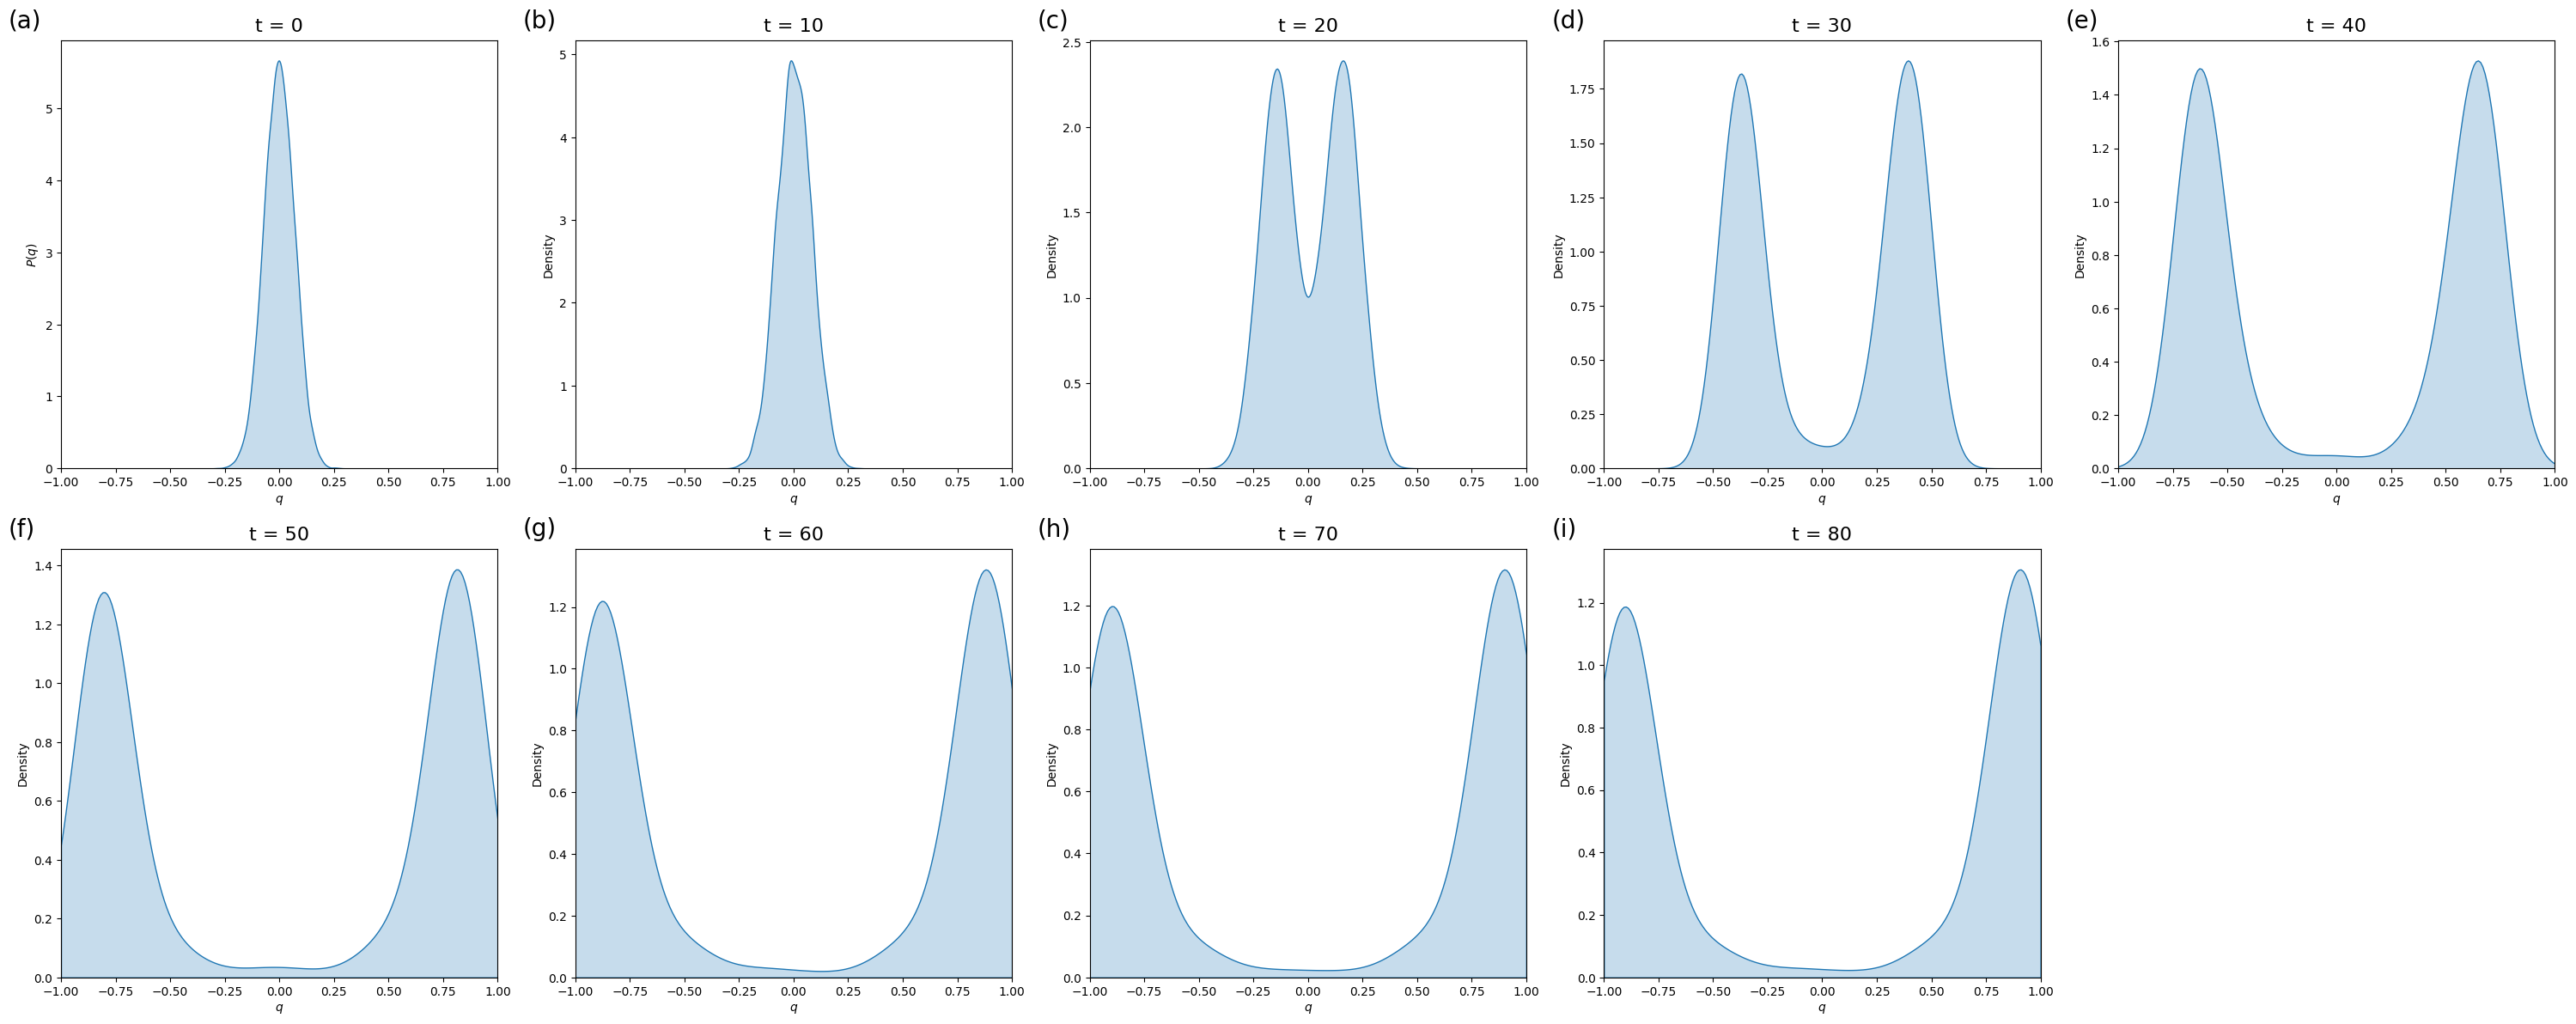

In [22]:
n_timesteps = 8
timesteps = [0, 10, 20, 30, 40, 50, 60, 70, 80]

fig, axarr = plt.subplots(2, 5, figsize=(30, 12))
axarr = axarr.flatten()

k_disorder = 0
iT = 2

for ell in range(n_timesteps+1):
    sns.kdeplot(FULLqlist_forward[k_disorder, ell, :, iT], fill=True, ax=axarr[ell], clip=(-1, 1))
    axarr[ell].set_xlim(-1, 1)
    axarr[ell].set_xlabel(r'$q$')
    if ell == 0:
        axarr[ell].set_ylabel(r'$P(q)$')
    axarr[ell].text(-0.12, 1.03, abclist[ell], transform=axarr[ell].transAxes, size=20)
    axarr[ell].text(0.5, 1.02, f't = {int(timesteps[ell])}', transform=axarr[ell].transAxes, 
                horizontalalignment='center', size=16)
if len(axarr) > n_timesteps+1:
    for extra_ax in axarr[n_timesteps+1:]:
        extra_ax.axis('off')

plt.tight_layout()
plt.show()

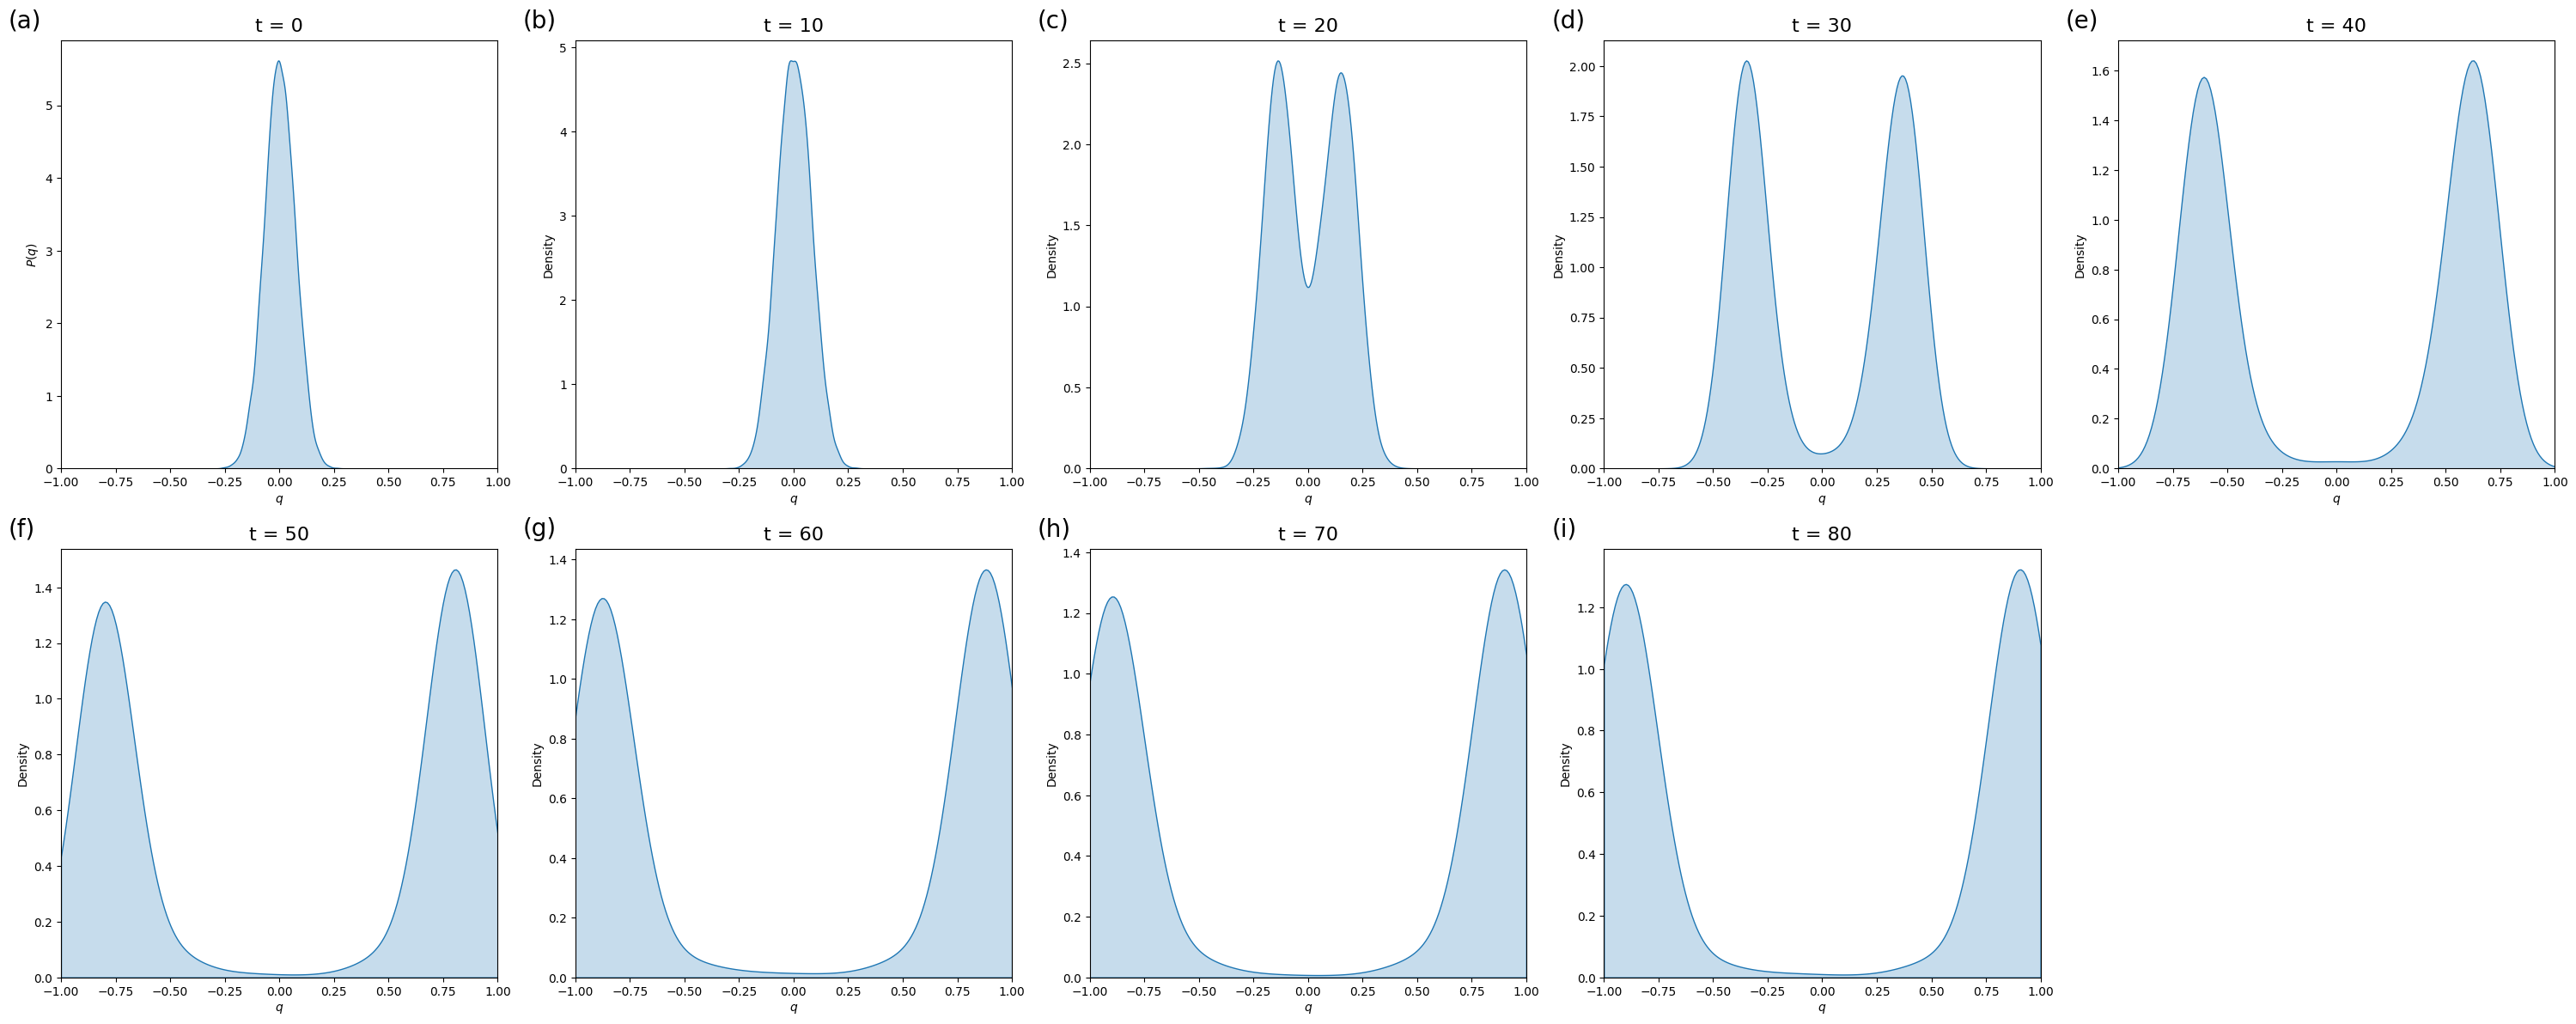

In [23]:
n_timesteps = 8
timesteps = [0, 10, 20, 30, 40, 50, 60, 70, 80]

fig, axarr = plt.subplots(2, 5, figsize=(30, 12))
axarr = axarr.flatten()

k_disorder = 0
iT = 2

for ell in range(n_timesteps+1):
    sns.kdeplot(FULLqlist_forward_sde[k_disorder, ell, :, iT], fill=True, ax=axarr[ell], clip=(-1, 1))
    axarr[ell].set_xlim(-1, 1)
    axarr[ell].set_xlabel(r'$q$')
    if ell == 0:
        axarr[ell].set_ylabel(r'$P(q)$')
    axarr[ell].text(-0.12, 1.03, abclist[ell], transform=axarr[ell].transAxes, size=20)
    axarr[ell].text(0.5, 1.02, f't = {int(timesteps[ell])}', transform=axarr[ell].transAxes, 
                horizontalalignment='center', size=16)
if len(axarr) > n_timesteps+1:
    for extra_ax in axarr[n_timesteps+1:]:
        extra_ax.axis('off')

plt.tight_layout()
plt.show()